# References:

### 1. [Coding With Qiskit - 1.x by Qiskit](https://www.youtube.com/playlist?list=PLOFEBzvs-VvrgHZt3exM_NNiNKtZlHvZi)
### 2. [AerSimulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html)
### 3. [Optimizer Ref 1](https://arxiv.org/pdf/2111.13454)
### 4. [Optimizer Ref 2](https://arxiv.org/pdf/2208.10285)
### 5. [Ansatz](https://github.com/comp-physics/qce23-qpde-tutorial/blob/master/Session2%20Notebook/1DPoisson%2BVQE.ipynb)
### 6. [An Empirical Analysis on the Effectiveness of the Variational Quantum Linear Solver](https://arxiv.org/abs/2409.06339)
### 7. [Variational quantum linear solver with a dynamic ansatz](https://link.aps.org/accepted/10.1103/PhysRevA.105.012423)
### 8. [Accelerating large-scale linear algebra using variational quantum imaginary time evolution](https://arxiv.org/abs/2503.13128)
### 9. [A Variational Quantum Linear Solver Application to Discrete Finite-Element Methods](https://www.mdpi.com/1099-4300/25/4/580)
### 10. [vqls-prototype](https://github.com/QuantumApplicationLab/vqls-prototype/blob/main/docs/technical_docs/vqls.md)


❗️ Adding more layers increases error accumulation and execution time exponentially [7].

Dynamic ansatz strategies adaptively increase the number of layers, thereby reducing both resource usage and circuit depth; this approach has been shown to yield fewer gates and faster convergence in tested systems.

❗️ Designing sufficiently expressive circuits becomes challenging for large N [6].

❗️ For large, sparse systems, classical preprocessing techniques such as graph partitioning help reduce matrix density and the "fill-in" effect, thereby lowering the cost of VQLS. 

Quantum approaches based on graph partitioning show promising potential in this area. [8]

In [15]:
import numpy as np
import scipy.linalg as la
from scipy.optimize import minimize
import math
import random

import qiskit as qiskit
from qiskit import transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.circuit.library import EfficientSU2

from qiskit_algorithms.optimizers import COBYLA

from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, OptionsV2
from qiskit_ibm_runtime.options import EstimatorOptions


# Prepare the Linear System:

In [16]:
N = 9
n = N - 1
L = 1.0
dx = L / N

xs_a = 0.1
xs_s = 0.9
mu_bar = 0.7
S = 1.0

xs_tr = xs_a + xs_s*(1-mu_bar)
D = 1 / (3*xs_tr)

def diffusion_matrix(D, xs_a): #finite difference
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 2 * D / dx**2 + xs_a
        if i > 0:
            A[i, i - 1] = -D / dx**2
        if i < n - 1:
            A[i, i + 1] = -D / dx**2
    return A

A = diffusion_matrix(D, xs_a)
b = np.full(n, S * dx)
b_norm = b / np.linalg.norm(b)

classical_solution = la.solve(A, b_norm)
ref_solution = classical_solution / np.linalg.norm(classical_solution)
print("Classical solution:", classical_solution)
print("Reference solution:", ref_solution)

Classical solution: [0.01918299 0.03354728 0.04311256 0.04789192 0.04789192 0.04311256
 0.03354728 0.01918299]
Reference solution: [0.18052656 0.31570546 0.40572195 0.45069937 0.45069937 0.40572195
 0.31570546 0.18052656]


# Real backend (ref[2]):

In [17]:
backend_name = "ibm_brisbane"
backend_real = QiskitRuntimeService().backend(backend_name)

service = QiskitRuntimeService(name = "melekderman")
backend_real = service.backend(name = "ibm_brisbane")

# Simulating with Aer (ref[1]):

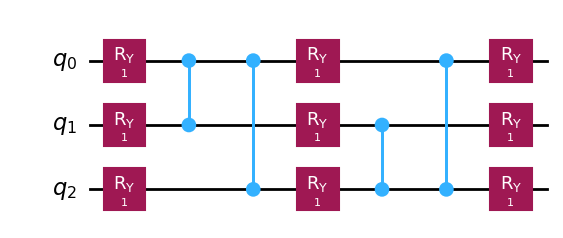

In [18]:
# from ref #10
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw('mpl')

In [6]:
# from ref #10
# Creates the Hadamard test

def had_test(circ, gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)

In [7]:
# from ref #10
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test


def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw('mpl')

# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw()


»
q2_0: ────■────────■────────■──────■───────■────■───────■──────■────────■────»
      ┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐    │    »
q2_1: ┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├────┼────»
      └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘┌───┴───┐»
q2_2: ─────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────┤ Ry(1) ├»
               └───────┘┌───┴───┐  │   │   │    │       │           └───────┘»
q2_3: ──────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼────────────────────»
                        └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  »
q2_4: ───────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────────────────»
                                 └───┘   └───┘└───┘   └───┘                  »
«                                                                    
«q2_0: ────■──────■───────■────■───────■──────■────────■────────■────
«          │      │       │    │       │  ┌───┴───┐    │        │    
«q2_1: ────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────
«          │      │       │    │       │  └───────┘┌───┴───┐    │    
«q2_2: ────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────
«      ┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐
«q2_3: ┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├
«      └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘
«q2_4: ─────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────
«               └───┘   └───┘└───┘   └───┘

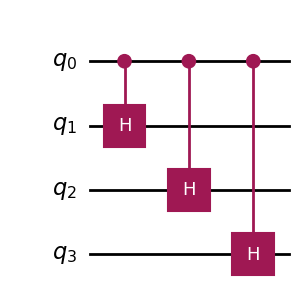

In [8]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4)
control_b(0, [1, 2, 3])
circ.draw('mpl')

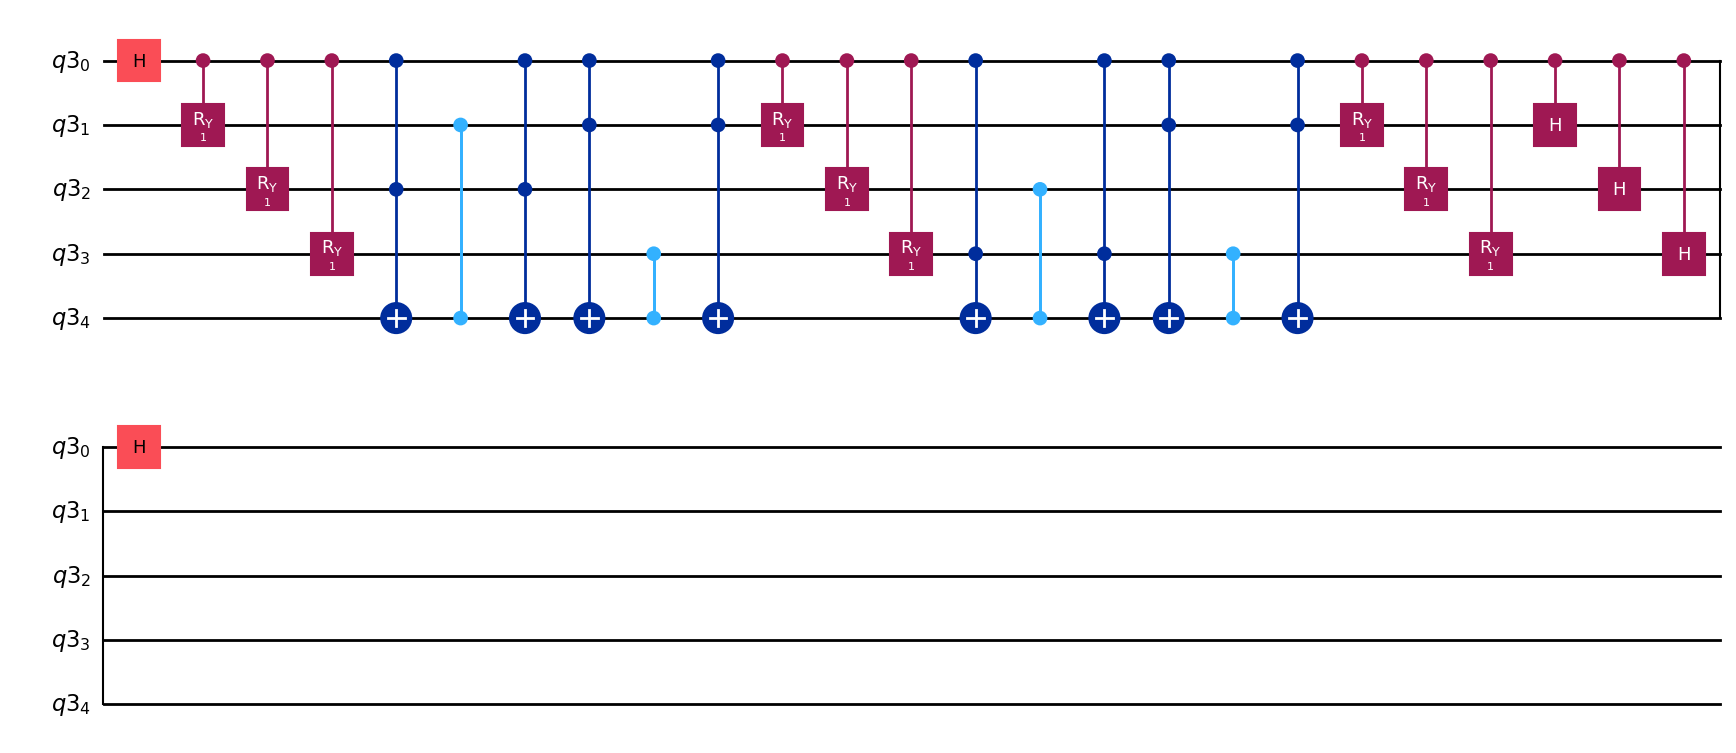

In [9]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(circ, gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])


    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test(circ, [[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw('mpl')

In [10]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(x):
    
    global opt

    overall_sum_1 = 0
    parameters = x.reshape((3, n_qubits))
    #parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i, G1 in enumerate(gate_set):
        for j, G2 in enumerate(gate_set):

            global circ

            qctl = QuantumRegister(n_qubits+1)
            qc = ClassicalRegister(n_qubits+1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('aer_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test(
                circ,
                [G1, G2],
                list(range(1, n_qubits+1)),
                0,
                parameters
            )

            circ.save_statevector()
            t_circ = transpile(circ, backend)
            job = backend.run(t_circ)

            result = job.result()
            outputstate = np.real(result.get_statevector(circ, decimals=100))
            o = outputstate

            m_sum = 0
            for l in range (0, len(o)):
                if (l%2 == 1):
                    n = o[l]**2
                    m_sum+=n

            overall_sum_1+=multiply*(1-(2*m_sum))

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(5)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                if (extra == 0):
                    special_had_test(circ, gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(circ, gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.save_statevector()    
                t_circ = transpile(circ, backend)
                job = backend.run(t_circ)
    
                result = job.result()
                outputstate = np.real(result.get_statevector(circ, decimals=100))
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]**2
                        m_sum+=n
                mult = mult*(1-(2*m_sum))

            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [11]:
# Prepare the quantum circuit
n_qubits = int(np.ceil(np.log2(len(b_norm))))       # number of qubits
print(f"Using {n_qubits} qubit(s) to encode {len(b_norm)} amplitude.")

# Aer simulator backend
noise_model = NoiseModel.from_backend(backend_real)
backend = AerSimulator(method='automatic', noise_model=False)

# |b> state preparation
qc_b = QuantumCircuit(n_qubits)                     
qc_b.initialize(b_norm, list(range(n_qubits)))

# Convert A matrix to SparsePauliOp
A_op = SparsePauliOp.from_operator(A)
pauli_labels  = A_op.paulis.to_labels()
pauli_coeffs  = A_op.coeffs

gate_set        = []
coefficient_set = []
for lbl, c in zip(pauli_labels, pauli_coeffs):
    mask = [1 if p!='I' else 0 for p in lbl]
    gate_set.append(mask)
    coefficient_set.append(np.real(c))
    

x0 = [random.random() * np.pi for _ in range(3*n_qubits)]
res = minimize(calculate_cost_function,
               x0=x0,
               method="COBYLA",
               options={'maxiter':20})
opt_params = res.x.reshape((3, n_qubits))
print("Optimal parameters:", opt_params)


Using 3 qubit(s) to encode 8 amplitude.
0.7662998157975281
0.5862114246670393
0.6991579912929622
0.6781404669285376
0.32281804069607256
0.5241666233518034
0.33943782767241526
0.34005232775914895
0.45687366670209584
0.39169539883730264
0.3354495620019967
0.37709271909490694
0.3208484394832025
0.41985128291574547
0.2720148239132403
0.3941500879743043
0.285336954866357
0.4076330212150929
0.30596211594279177
0.3551673547808947
Optimal parameters: [[3.75389205 2.02802441 2.54109848]
 [4.07568386 1.3083552  2.72712951]
 [0.42562034 2.50116252 1.56268419]]
